In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

df = pd.read_csv('/content/sample_data/07_train.csv')

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# split target and features
X_train = train_set.drop('Premium Amount', axis=1)
y_train = train_set['Premium Amount'].copy()
X_test = test_set.drop('Premium Amount', axis=1)
y_test = test_set['Premium Amount'].copy()

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [2]:
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

## Momentum

In [3]:
# cyclic momentum
class CyclicMomentumScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, start_lr=1e-4, max_lr=1e-3, start_mom=0.9, final_mom=0.7, cyclic_mom=False, cyclic_lr=False):
        self.iterations = iterations
        self.start_lr = start_lr
        self.max_lr = max_lr
        self.start_mom = start_mom
        self.final_mom = final_mom
        self.iteration = 0
        self.lr = []
        self.cyclic_mom = cyclic_mom
        self.cyclic_lr = cyclic_lr
        self.current_lr = start_lr

    def _interpolate(self, iter1, iter2, lr1, lr2):
        slope = (lr2 - lr1) / (iter2 - iter1)
        delta = self.iteration - iter1
        return delta * slope + lr1

    def on_batch_begin(self, batch, logs=None):
        # learning rate
        if self.cyclic_lr:
            lr = self._interpolate(0, self.iterations, self.start_lr, self.max_lr)
            self.current_lr = lr
            lr = float(lr)
            self.model.optimizer.learning_rate.assign(lr)

        # momentum
        if self.cyclic_mom:
            mom = self._interpolate(0, self.iterations, self.start_mom, self.final_mom)
            mom = float(mom)
            self.model.optimizer.momentum = mom
        self.iteration += 1

    # add learning rate to history
    def on_epoch_begin(self, epoch, logs):
        print(self.current_lr)
        print(self.model.optimizer.momentum)
        self.lr.append(float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)))

### Constant vs Decreasing Momentum
- model 1: 0.9 (LR=0.006)
- model 2: 0.97-0.7 (CLR=0.001-0.006)

WD: 1e-6

In [4]:
# model 1: 0.9 (LR=0.006)
import math

model = tf.keras.Sequential()

for i in range(5):
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))

model.add(tf.keras.layers.Dense(1))

model.compile(
    loss=root_mean_squared_error,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.006, weight_decay=1e-6, momentum=0.9),
    )

n_epochs = 20
batch_size = 128
iterations = math.ceil(len(X_train) / batch_size) * n_epochs

callbacks = [CyclicMomentumScheduler(
                         iterations, cyclic_mom=False, cyclic_lr=False)]

history9 = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                     callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


0.0001
0.9
Epoch 1/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 1.2217 - val_loss: 1.1140
0.0001
0.9
Epoch 2/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 1.0939 - val_loss: 1.1015
0.0001
0.9
Epoch 3/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 1.0908 - val_loss: 1.6077
0.0001
0.9
Epoch 4/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0872 - val_loss: 1.6367
0.0001
0.9
Epoch 5/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 1.0853 - val_loss: 1.0885
0.0001
0.9
Epoch 6/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0856 - val_loss: 1.1020
0.0001
0.9
Epoch 7/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 1.0848 - val_loss: 1.1052
0.0001
0.9
Epoch 8/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0850 - val_loss: 1.7616
0.0001
0.9
Epoch 9/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 1.0833 - val_loss: 1.0895
0.0001
0.9
Epoch 10/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0837 - val_loss: 1.5152

In [5]:
# model 2: 0.97-0.7 (CLR=0.002-0.006)
model = tf.keras.Sequential()

for i in range(5):
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))

model.add(tf.keras.layers.Dense(1))

model.compile(
    loss=root_mean_squared_error,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, weight_decay=1e-6, momentum=0.97),
    )

n_epochs = 20
batch_size = 128
iterations = math.ceil(len(X_train) / batch_size) * n_epochs

callbacks = [CyclicMomentumScheduler(
                         iterations, cyclic_mom=True, cyclic_lr=True,
                         start_lr=0.002, max_lr=0.006,
                         start_mom=0.97, final_mom=0.7)]

history10 = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                     callbacks=callbacks)

0.002
0.97
Epoch 1/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 1.2857 - val_loss: 1.1235
0.002199973333333333
0.9565018
Epoch 2/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 1.1005 - val_loss: 3.2521
0.0023999733333333333
0.9430018
Epoch 3/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0906 - val_loss: 1.6381
0.0025999733333333334
0.9295017999999999
Epoch 4/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0896 - val_loss: 1.1011
0.0027999733333333335
0.9160018
Epoch 5/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 1.0880 - val_loss: 1.0889
0.0029999733333333336
0.9025018
Epoch 6/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.0860 - val_loss: 1.3041
0.003199973333333333
0.8890018
Epoch 7/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 1.0832 - val_loss: 1.0888
0.0033999733333333333
0.8755018
Epoch 8/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0854 - val_loss: 1.1523
0.0035999733333333334
0.8620017999999999
Epoch

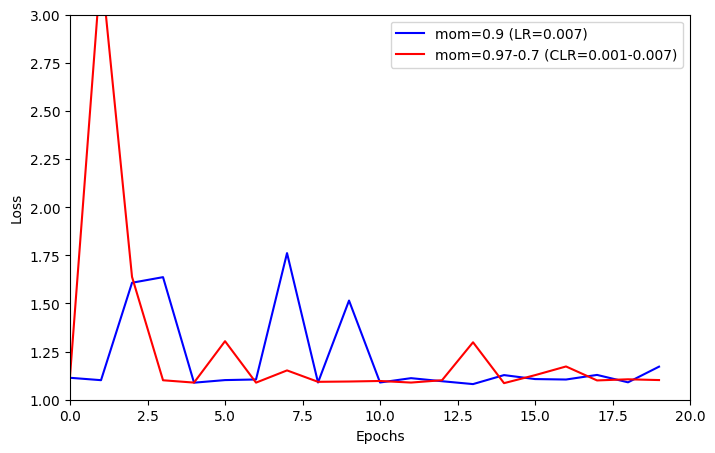

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.plot(history9.history['val_loss'], 'b-', label='mom=0.9 (LR=0.007)')
plt.plot(history10.history['val_loss'], 'r-', label='mom=0.97-0.7 (CLR=0.001-0.007)')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([0, 20])
plt.ylim([1, 3])
plt.legend()
plt.show()